# Separating A Capella Songs into their Separated Vocal Tracks

One A Capella song is usually made up by 5-8 singers singing their respective parts together to form mainly the **lead_vocal, soprano, alto, bass, tenor, and vocal percussion.** <br>

In this notebook, we aim to **train our own Machine Learning Model** to **separate these 6 main tracks** from one another, given an A Capella song audio input. We will be using a dataset with Japanese A Capella songs (Ja Capella).

In [1]:
import glob
import math
import zipfile
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import IPython.display as ipd

from glob import glob

In [2]:
# Please ensure to have downloaded Ja Capella dataset and followed instructions from README.md before continuing

with zipfile.ZipFile("Dataset/Jacapella.zip", 'r') as zip_ref:
        zip_ref.extractall("Dataset/Jacapella")

In [2]:
df = pd.read_csv('Dataset/Jacapella/meta.csv')

In [3]:
df.sample(5)

,title_in_en,title_in_ja,lyric_writer,copyright_of_lyric_writer,composer,copyright_of_composer,arranger_in_en,arranger_in_ja,subset,voice_part,singer_id,gender,first_lang
129,omochanomaachi,おもちゃのマーチ,海野厚,PD,小田島樹人,PD,Kana Yokoi,横井香菜,reggae,tenor,T3,male,ja
98,kutsuganaru,靴が鳴る,清水かつら,PD,弘田龍太郎,PD,Miwa Nomura,野村美和,popular,alto,A1,female,ja
116,chatsumi,茶摘,作詞者不詳（文部省唱歌）,PD,作曲者不詳（文部省唱歌）,PD,Miwa Nomura,野村美和,popular,alto,A1,female,ja
110,yuki,雪,作詞者不詳（文部省唱歌）,PD,作曲者不詳（文部省唱歌）,PD,Miwa Nomura,野村美和,popular,alto,A1,female,ja
197,hato,鳩,作詞者不詳（文部省唱歌）,PD,作曲者不詳（文部省唱歌）,PD,Mika Sato,佐藤美香,neutral,vocal_percussion,VP4,male,ja


In [4]:
# create df_mix to show all the combines audio of mixed voice parts for each song
# append their file directory into the df_mix as well

titles = []
subset = []
file_dir = []
voice_part = []
for index in df.index:
    if df.iloc[index,0] not in titles:
        titles.append(df.iloc[index,0])
        subset.append(df.iloc[index,8])
        voice_part.append("mixture")
        file_dir.append(f"Dataset/Jacapella/{df.iloc[index,8]}/{df.iloc[index,0]}/mixture.wav")
        
df_mix = pd.DataFrame([], columns=['title_in_en', 'subset','voice_part','audio_file_dir'])
df_mix['title_in_en'] = titles
df_mix['subset'] = subset
df_mix['voice_part'] = voice_part
df_mix['audio_file_dir'] = file_dir

In [5]:
# Appending file directory of each vocal track
audio_file_dir = []
for index in df.index:
    title = df.iloc[index,0]
    subset = df.iloc[index,8]
    voice = df.iloc[index,9]
    audio_file_dir.append("Dataset/Jacapella/" + str(subset) + "/" + str(title) + "/" + str(voice) + ".wav")

# Added new column in df_audio to show each audio track's directory
df["audio_file_dir"] = audio_file_dir


In [6]:
# creating separate df for each vocal parts

df_leadvocal = pd.DataFrame()
df_soprano = pd.DataFrame()
df_alto = pd.DataFrame()
df_tenor = pd.DataFrame()
df_bass = pd.DataFrame()
df_percussion = pd.DataFrame()

for index,value in df.iterrows():
    if df.iloc[index, 9] == "lead_vocal":
        df_leadvocal = df_leadvocal.append(value, ignore_index = True)
    elif df.iloc[index, 9] == "soprano":
        df_soprano = df_soprano.append(value, ignore_index = True)
    elif df.iloc[index, 9] == "alto":
        df_alto = df_alto.append(value, ignore_index = True)
    elif df.iloc[index, 9] == "tenor":
        df_tenor = df_tenor.append(value, ignore_index = True)
    elif df.iloc[index, 9] == "bass":
        df_bass = df_bass.append(value, ignore_index = True)
    else:
        df_percussion= df_percussion.append(value, ignore_index = True)

C:\Users\65900\AppData\Local\Temp\ipykernel_1340\2684089937.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_leadvocal = df_leadvocal.append(value, ignore_index = True)
C:\Users\65900\AppData\Local\Temp\ipykernel_1340\2684089937.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_soprano = df_soprano.append(value, ignore_index = True)
C:\Users\65900\AppData\Local\Temp\ipykernel_1340\2684089937.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_alto = df_alto.append(value, ignore_index = True)
C:\Users\65900\AppData\Local\Temp\ipykernel_1340\2684089937.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tenor = df_ten

In [7]:
df_leadvocal.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_soprano.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_alto.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_tenor.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_bass.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_percussion.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)


# Listen to an example of Jacapella :D

In [ ]:
# Listen to an example of Jacapella :D
random.seed(0)
rand = random. randint(1,35)

print(f"Mixture audio for {df_mix.iloc[rand,0]}")
ipd.Audio(df_mix.iloc[rand,3])

In [ ]:
print(f"Soprano audio for {df_soprano.iloc[rand,0]}")
ipd.Audio(df_soprano.iloc[rand,3])

In [ ]:
print(f"Alto audio for {df_alto.iloc[rand,0]}")
ipd.Audio(df_alto.iloc[rand,3])

In [ ]:
print(f"Bass audio for {df_bass.iloc[rand,0]}")
ipd.Audio(df_bass.iloc[rand,3])

In [ ]:
print(f"Tenor audio for {df_tenor.iloc[rand,0]}")
ipd.Audio(df_tenor.iloc[rand,3])

In [ ]:
print(f"Percussion audio for {df_percussion.iloc[rand,0]}")
ipd.Audio(df_percussion.iloc[rand,3])

In [ ]:
print(f"Lead Vocal audio for {df_leadvocal.iloc[rand,0]}")
ipd.Audio(df_leadvocal.iloc[rand,3])

# Data Visualisation

In [ ]:
# Total of 7 genres, each has 5 songs.Each songs have 6 vocal parts.
df_mix['subset'].value_counts().plot(kind='bar', figsize=(10,3))
plt.xlabel("Genre")
plt.xticks(rotation=0)
plt.ylabel("Number of Samples")

**Amplitude Change for each vocal part**

The graph displays the time on the horizontal (X) axis and the amplitude on the vertical (Y) axis but it doesn’t tell us what’s happening to frequencies.

In [8]:
# Add audio time series for each audio track

def add_time_series(df):
    
    # audio time series describes the amplitude of the audio at different timesteps.
    audio_time_series = []

    # sampling rate, sr
    sampling_rate = []

    for index, data in df.iterrows():
        y, sr = librosa.load(data['audio_file_dir'])
        audio_time_series.append(y)
        sampling_rate.append(sr)

    df["audio_time_series"] = audio_time_series
    df['sampling_rate'] = sampling_rate
    return df

In [9]:
dfs = [df_leadvocal, df_soprano, df_alto, df_tenor, df_bass, df_percussion, df_mix]

In [10]:
for df in dfs:
    add_time_series(df)

In [ ]:
# Visualise Amplitude Change which is the change of pressure near the microphone or recording device 
# for different vocal parts of 1 song

dfs = [df_leadvocal, df_soprano, df_alto, df_tenor, df_bass, df_percussion, df_mix]
random.seed(0)
rand = random. randint(1,35) 

def visualise_amp(df, index):
    row = df.iloc[index, :]
    pd.Series(row['audio_time_series']).plot(figsize=(10, 5), lw=1)
    plt.title(f"Amplitude change for {row['voice_part']} in {row['title_in_en']}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    plt.tight_layout()

In [ ]:
for df in dfs:
    visualise_amp(df, rand)

# Feature Engineering

**1. Zero Crossing Rate (ZCR)**

The zero-crossing rate describes the rate at which a signal moves from positive to zero to negative or from negative to zero to positive. The feature is used in music retrieval systems to identify noisy signals.

ZCR is a feature often used in signal processing and audio analysis. Change in ZCR could be due to transitioning from silence to sound, or change in pitch, or change in environmental sound.

In [11]:
# Concat all dfs tgt 

df_all = pd.concat([df_leadvocal, df_soprano, df_alto, df_tenor, df_bass, df_percussion, df_mix], axis=0, ignore_index = True)
df_all['voice_part'].nunique()

df_all.sample(5)

,title_in_en,subset,voice_part,audio_file_dir,audio_time_series,sampling_rate
126,omochanomaachi,reggae,tenor,Dataset/Jacapella/reggae/omochanomaachi/tenor.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
117,ryousen,bossa_nova,tenor,Dataset/Jacapella/bossa_nova/ryousen/tenor.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
168,koujounotsuki,enka,bass,Dataset/Jacapella/enka/koujounotsuki/bass.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
77,shabondama,punk_rock,alto,Dataset/Jacapella/punk_rock/shabondama/alto.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
9,chouchou,punk_rock,lead_vocal,Dataset/Jacapella/punk_rock/chouchou/lead_voca...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050


In [12]:
def zcr(df):
    ZCR = []
    for index, song in df.iterrows():
        zero_crossings = librosa.zero_crossings(song['audio_time_series'],pad=False)
        ZCR.append(sum(zero_crossings))

    df["zcr"] = ZCR
    return df

zcr(df_all)

,title_in_en,subset,voice_part,audio_file_dir,audio_time_series,sampling_rate,zcr
0,otamajakushi,jazz,lead_vocal,Dataset/Jacapella/jazz/otamajakushi/lead_vocal...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,60560
1,popura,jazz,lead_vocal,Dataset/Jacapella/jazz/popura/lead_vocal.wav,"[-5.388835e-08, -6.140749e-08, -5.7947744e-08,...",22050,112607
2,nanatsunoko,jazz,lead_vocal,Dataset/Jacapella/jazz/nanatsunoko/lead_vocal.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,101862
3,akaikutsu,jazz,lead_vocal,Dataset/Jacapella/jazz/akaikutsu/lead_vocal.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,77660
4,machibouke,jazz,lead_vocal,Dataset/Jacapella/jazz/machibouke/lead_vocal.wav,"[-5.388835e-08, -6.140749e-08, -5.7947744e-08,...",22050,72365
...,...,...,...,...,...,...,...
240,katatsumuri,neutral,mixture,Dataset/Jacapella/neutral/katatsumuri/mixture.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,51254
241,komoriuta,neutral,mixture,Dataset/Jacapella/neutral/komoriuta/mixture.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,86296
242,hato,neutral,mixture,Dataset/Jacapella/neutral/hato/mixture.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,47526
243,harugakita,neutral,mixture,Dataset/Jacapella/neutral/harugakita/mixture.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,47256


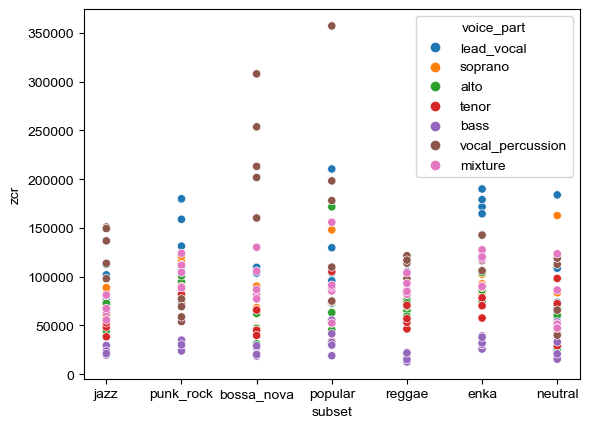

In [13]:
# plot 2-D btw voice part & ZCR
#df_audio[['subset', 'zcr']].plot(kind='scatter', x='subset', y='zcr')

sns.scatterplot(x='subset', y='zcr', hue='voice_part', data=df_all)
sns.set(rc = {'figure.figsize':(10, 10)})
plt.show()

In [14]:
# Add zcr into each individual dfs
for df in dfs:
    zcr(df)


**2. Spectral Centroid** <br>

It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. 

In [ ]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
import sklearn

def spectral_centr(df):
    num_frames = []
    centroids = []
    for index, data in df.iterrows():
        x = data['audio_time_series']
        spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=data['sampling_rate'])
#         print(spectral_centroids.shape[1])
#         print(spectral_centroids[0])
        num_frames.append(spectral_centroids.shape[1])

        # Computing the time variable for visualization
        frames = range(len(spectral_centroids[0]))
        t = librosa.frames_to_time(frames)

        centroids.append([spectral_centroids[0],t])
        
    df['num_frames'] = num_frames
    df['spectral_centroid'] = centroids
        
    return df


In [ ]:
for df in dfs:
    spectral_centr(df)


**3. MFCC — Mel-Frequency Cepstral Coefficients** <br>

MFCCs of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. 

MFCC is used for deduction of noise in audios and also used for audio classification. They represent the audio's spectral characteristics and are commonly used in audio processing tasks such as music information retrieval and speech recognition.

In [ ]:
def mfcc(df):
    mfcc_coefficient = []
    for index, data in df.iterrows():
        mfcc = librosa.feature.mfcc(y= data['audio_time_series'], sr= data['sampling_rate'])
        mfcc_coefficient.append(mfcc)
        
    df['mfcc'] = mfcc_coefficient
    return df

In [ ]:
for df in dfs:
    mfcc(df)

**4. Short-Term Fourier Transform (STFT)** <br>

Its complex-valued coefficients provide the frequency and phase content of local sections of a signal as it evolves over time.

In [ ]:
def stft(df):
    stft = []
    for index, data in df.iterrows():
        
        # Return the complex Short Term Fourier Transform
        y = data['audio_time_series']
        sound_stft = np.abs(librosa.stft(y))
        stft.append(sound_stft)
                                       
    df['stft'] = stft
    return df

In [ ]:
for df in dfs:
    stft(df)

**Magnitude Spectrogram**

A spectrogram is a detailed view of a signal that covers all three characteristics of sound.<br> 
X-axis represents time, Y-axis represent frequency, color represents amplitude. 

The louder the event the brighter the color, while silence is represented by black.

In [ ]:
# Magnitude spectrogram that visualises the 3 aspects of STFT

random.seed(0)
rand = random. randint(1,35) 

def spectrogram(df, index):
    row = df.iloc[index, :]
#     X = librosa.stft(row['audio_time_series'])
    Xdb = librosa.amplitude_to_db(abs(row['stft']))
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(Xdb, sr=row['sampling_rate'], x_axis='time', y_axis='hz') 
    plt.title(f"Spectrogram for {row['voice_part']} in {row['title_in_en']}")
    plt.colorbar()

In [ ]:
for df in dfs:
    spectrogram(df, rand)

**5. Pitch Features**

In [ ]:
# EDA on pitch features
# Lists to store pitch analysis results

def extract_pitch_and_analyze(df):
    mean_pitch_list = []
    median_pitch_list = []
    min_pitch_list = []
    max_pitch_list = []
#     pitch_compile = []
    
    # Function to extract pitch and perform analysis
    for index, data in df.iterrows():
        # Extract pitch features using the YIN algorithm
        pitch, magnitudes = librosa.piptrack(y=data['audio_time_series'], sr=data['sampling_rate'])
        pitch = pitch[pitch > 0]  # Filter out non-positive pitch values
#         pitch_compile.append(pitch)
        
        # Calculate pitch statistics
        mean_pitch = pitch.mean()
        median_pitch = np.median(pitch)
        min_pitch = pitch.min()
        max_pitch = pitch.max()

        # Append pitch statistics to the respective lists
        mean_pitch_list.append(mean_pitch)
        median_pitch_list.append(median_pitch)
        min_pitch_list.append(min_pitch)
        max_pitch_list.append(max_pitch)
    
#     df['pitch'] = pitch
    df['mean_pitch'] = mean_pitch_list
    df['median_pitch'] = median_pitch_list
    df['min_pitch'] = min_pitch_list
    df['max_pitch'] = max_pitch_list

In [ ]:
# calc mean pitch for individual vocal parts and put into their own dataframes.
for df in dfs:
    extract_pitch_and_analyze(df)
    

In [ ]:
# combine mean pitch for all vocal parts tgt to show histogram
extract_pitch_and_analyze(df_all)

In [ ]:
# histogram with hue based on 'voice_part' for mean pitch
plt.figure(figsize=(10, 6))
sns.histplot(data=df_all, x='mean_pitch', hue='voice_part', element='step', bins=20, kde=True, hue_order=df_all['voice_part'].unique())
plt.title("Histogram of Mean Pitch by Voice Part")
plt.xlabel("Mean Pitch")
plt.ylabel("Frequency")
plt.legend(title="Voice Part", labels=df_all['voice_part'].unique())
plt.figure(figsize=(10, 6))
plt.show()

**6. Chroma feature extraction** <br>

Chroma feature extraction is a technique commonly used in music signal processing to represent the harmonic content of an audio signal. <br> It aims to capture the distribution of pitch classes, which are the 12 distinct notes in the Western music scale (C, C#, D, D#, E, F, F#, G, G#, A, A#, B).

In [ ]:
def chroma(df):
    chroma_feature = []
    for index, data in df.iterrows():
        # Compute chroma feature
        chroma = librosa.feature.chroma_stft(y=data['audio_time_series'], sr=data['sampling_rate'])
        chroma_feature.append(chroma)
    df['chroma'] = chroma_feature

In [ ]:
for df in dfs:
    chroma(df)

In [ ]:
random.seed(0)
rand = random. randint(1,35) 

def visualise_chroma(df, index):
    # Get the randomly selected song title row's data
    row = df.iloc[index,:]
    
    # Visualize the Chroma feature matrix for diff parts of that same song
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(row['chroma'], y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(f"Chroma Feature for {row['voice_part']} in {row['title_in_en']} ")
    plt.xlabel("Time (s)")
    plt.ylabel("Chroma")
    plt.show()


In [ ]:
for df in dfs:
    visualise_chroma(df, rand)

# Non-negative matrix factorization (NMF) 

NMF is a powerful sound source separation technique that can extract individual sound sources from a mixture of sounds.